In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.interpolate import interp1d
from scipy.special import lambertw
from scipy.integrate import quad
from scipy.stats import linregress
from matplotlib.animation import FuncAnimation
import warnings

# Core Spacetime and Coordinate Functions

This module provides essential functions for Schwarzschild spacetime calculations, including the metric function and tortoise coordinate transformations.

# f_schwarzschild(r, M)

**Description:**  
Computes the Schwarzschild metric function 

$f(r) = 1 - \frac{2M}{r}$

for a given radial coordinate $r$ and black hole mass $M$. The function accounts for the horizon at $r = 2M$.

**Parameters:**  
- `r` : float or array-like — radial coordinate(s)  
- `M` : float — mass of the black hole  

**Returns:**  
- float or ndarray — value(s) of $f(r)$. Returns $0.0$ for $r \le 2M$.

**Notes:**  
- Returns `-np.inf` for $r \le 0$.  
- For $r \le 2M$ (inside horizon), function returns $0.0$.  

**Example:**  
```python
f_schwarzschild(3.0, 1.0)  # Output: 0.3333...


# Numerical Interpolator Construction for Schwarzschild r* Coordinates

This module provides functions to construct **robust numerical interpolators** for converting between the Schwarzschild radial coordinate $r$ and the tortoise coordinate $r_*$.  

It uses a **hybrid approach**:  
- Analytical formulas near the horizon to avoid singularities.  
- Numerical integration and interpolation farther from the horizon.

---

# _rstar_integrand(r, f)

**Description:**  
Integrand $1/f(r)$ used for computing $r_*$ numerically. Handles the singularity at the event horizon.

**Parameters:**  
- `r` : float — radial coordinate  
- `f` : callable — metric function $f(r)$  

**Returns:**  
- float — $1/f(r)$ or $\infty$ at the horizon

---

# _analytical_rstar_near_horizon(r, r_+, kappa)

**Description:**  
Analytical formula for $r_*$ very close to the event horizon:

$r_* \approx \frac{1}{2 kappa} \ln(r - r_+)$

**Parameters:**  
- `r` : float — radial coordinate near horizon  
- `r_+` : float — horizon radius ($2M$)  
- `kappa` : float — surface gravity ($1/(4 M)$)  

**Returns:**  
- float — approximate $r_*$ near the horizon

---

# _rstar_of_r_hybrid(r_vals, f, r_+, kappa, eps)

**Description:**  
Hybrid calculation of $r_*(r)$ combining analytical near-horizon formula and numerical integration beyond a transition radius.

**Parameters:**  
- `r_vals` : array-like — grid of $r$ values  
- `f` : callable — metric function $f(r)$  
- `r_+` : float — horizon radius  
- `kappa` : float — surface gravity  
- `eps` : float — small offset from horizon  

**Returns:**  
- ndarray — $r_*$ values corresponding to `r_vals`

---

# make_rstar_interpolator_robust(M, r_max=500.0, n_points=20000, eps=1e-12)

**Description:**  
Precomputes $r_*(r)$ and returns two robust interpolators:  
1. $r_*(r)$ — calculates tortoise coordinate from radius  
2. $r(r_*)$ — calculates radius from tortoise coordinate  

Uses hybrid method:  
- Analytical formulas for $r_* < 0$  
- Cubic spline interpolation for $r_* \ge 0$

**Parameters:**  
- `M` : float — black hole mass  
- `r_max` : float — maximum radius for interpolator  
- `n_points` : int — number of grid points  
- `eps` : float — closest distance to horizon for the grid  

**Returns:**  
- tuple of callables `(rstar_of_r, r_of_rstar)`  

**Notes:**  
- Ensures smooth and precise conversion even near the horizon.  
- Clamps $r_* < -50$ to avoid numerical issues.  
- Uses cubic interpolation for robustness.

**Example:**  
```python
rstar_of_r, r_of_rstar = make_rstar_interpolator_robust(M=1.0)
r_star = rstar_of_r(3.0)
r = r_of_rstar(r_star)


# Black Hole Perturbation Potentials

This module defines several important potentials used in black hole perturbation theory:  
- Regge-Wheeler potential for axial perturbations  
- Zerilli potential for polar perturbations  
- Poschl-Teller potential as an analytic approximation

---

# V_RW(r, l, s)

**Description:**  
Regge-Wheeler potential for axial perturbations of a Schwarzschild black hole:

$V_{RW}(r) = \left(1 - \frac{2 M}{r}\right) \left(\frac{l(l+1)}{r^2} + \frac{2 (1 - s^2) M}{r^3}\right)$

**Parameters:**  
- `r` : float or array-like — radial coordinate(s)  
- `l` : int — angular momentum quantum number  
- `s` : int — spin of the perturbing field (0, 1, 2)  

**Returns:**  
- float or ndarray — value(s) of $V_{RW}(r)$

---

# V_ZP(r, l, s=None)

**Description:**  
Zerilli potential $V^+(r)$ for polar gravitational perturbations of a Schwarzschild black hole:

$n = 0.5 * (l - 1) * (l + 2)$

$f = 1 - \frac{2 M}{r}$

$V^+(r) = \frac{2 f \left(n^2 (n+1) r^3 + 3 M n^2 r^2 + 9 M n r + 9 M^3\right)}{r^3 (n r + 3 M)^2}$

**Parameters:**  
- `r` : array-like — radial coordinate(s)  
- `l` : int — angular momentum quantum number  
- `s` : ignored, for consistency  

**Returns:**  
- ndarray — $V^+(r)$ values, NaN for $r \le 2 M$

**Notes:**  
- Only computed for $r > 2 M$ (outside horizon)  

---

# V_PT(r, l=None, s=None)

**Description:**  
Poschl-Teller potential, often used as an analytic approximation for quasi-normal mode studies:

$V_{PT}(r) = \frac{0.15}{\cosh^2(0.1 r_*)}$

where $r_*$ is the Schwarzschild tortoise coordinate corresponding to $r$.

**Parameters:**  
- `r` : float or array-like — radial coordinate(s)  
- `l`, `s` : optional, ignored  

**Returns:**  
- float or ndarray — value(s) of $V_{PT}(r)$


# Plotting, Wave Evolution, and Signal Analysis Functions

This module provides functions to:
- Plot black hole potentials
- Evolve scalar fields on a 2D grid using finite differences
- Extract signals at specific observation points
- Perform QNM (Prony) analysis and late-time tail fitting

---

# plot_potential(potential_function, r_input, rstar_input, M=1.0, **kwargs)

**Description:**  
General plotting function for black hole potentials, showing:  
- $r$ vs $r_*$  
- $V(r)$ vs $r$  
- $V(r)$ vs $r_*$  

Also returns the maximum of the potential and its location.

**Parameters:**  
- `potential_function` : callable — function computing $V(r)$  
- `r_input` : array — radial coordinates $r > 2M$  
- `rstar_input` : array — tortoise coordinates $r_*$  
- `M` : float — black hole mass  
- `**kwargs` : extra arguments passed to potential function (e.g., l, s)  

**Returns:**  
- `Vmax` : float — maximum potential  
- `r_at_max` : float — $r$ at maximum  
- `rstar_at_max` : float — $r_*$ at maximum

---

# wave_integrator(u, v, potential_function, M=1.0, sigma=0.2, v0=2, ...)

**Description:**  
Evolve a scalar field $\psi(u,v)$ on a 2D $(u,v)$ grid using a finite difference scheme with a general potential. Initial condition is a Gaussian along $u=0$.

**Parameters:**  
- `u, v` : np.ndarray — grid points  
- `potential_function` : callable — $V(r, **kwargs)$  
- `M` : float — black hole mass  
- `sigma` : float — width of initial Gaussian  
- `v0` : float — center of Gaussian  
- `use_analytic` : bool — if True, use analytic $r \leftrightarrow r_*$ mapping  
- `rstar_of_r`, `r_of_rstar` : callable — numerical interpolators (required if `use_analytic=False`)  
- `**kwargs` : extra potential parameters  

**Returns:**  
- `psi` : np.ndarray — evolved field on the grid  
- `x_mid_list` : list — midpoint coordinates  
- `V_mid_list` : list — potential values at midpoints  
- `h` : float — grid spacing

---

# observe_signal(psi, u, v, x_obs, h, ...)

**Description:**  
Extract signal $\psi(t)$ at a given observation point $x_{\mathrm{obs}}$ in tortoise coordinates. Optionally plots the potential and the extracted signal.

**Parameters:**  
- `psi` : np.ndarray — 2D field array  
- `u, v` : np.ndarray — grid arrays  
- `x_obs` : float — observation point in $x_*$  
- `h` : float — grid spacing  
- `x_mid_list, V_mid_list` : list — optional midpoint and potential values for plotting  
- `plot_potential` : bool — whether to plot $V_{\mathrm{mid}}$ vs $x_{\mathrm{mid}}$  
- `mode` : str — "analytic" or "numerical"  
- `rstar_func, r_func` : callable — mapping functions for numerical mode  
- `M` : float — black hole mass  

**Returns:**  
- `signal_array` : np.ndarray — extracted signal $\psi(t)$  
- `time_array` : np.ndarray — corresponding times $t = (u+v)/2$

---

# analyze_signal(signal_array, time_array, t_fit_range, tail_fit_range, p=2, ...)

**Description:**  
Perform quasi-normal mode (QNM) analysis using the Prony method and fit the late-time tail of the signal.

**Parameters:**  
- `signal_array` : np.ndarray — observed signal at $x_{\mathrm{obs}}$  
- `time_array` : np.ndarray — corresponding times  
- `t_fit_range` : tuple — time interval for QNM fitting  
- `tail_fit_range` : tuple — time interval for late-time tail fitting  
- `p` : int — number of QNMs to extract  
- `mode` : str — "analytic" or "numerical"  
- `rstar_func, r_func` : callable — mapping functions for numerical mode  
- `M` : float — black hole mass  

**Returns:**  
- `omega_list` : list — extracted QNM complex frequencies $\omega = \omega_R - i \omega_I$

**Notes:**  
- Uses finite difference evolution and midpoint potentials for signal extraction.  
- Generates plots for:  
  - Original signal and Prony fit in the ringing region  
  - Late-time tail fit (log-log plot)  

**Example:**  
```python
signal, time = observe_signal(psi, u, v, x_obs=30.0, h=h)
omega_list = analyze_signal(signal, time, t_fit_range=(70,200), tail_fit_range=(350,450), p=2)


In [4]:
M = 1.0  # Mass of the black hole
epsilon = 1e-5  # Small offset to avoid horizon singularity

# ==============================================================================
# --- Core Spacetime and Coordinate Functions ---
# ==============================================================================

def f_schwarzschild(r, M):
    """Metric function f(r) for Schwarzschild spacetime."""
    r = np.asarray(r)
    result = np.where(r > 0, 1 - 2 * M / r, -np.inf)
    result[r <= 2 * M] = 0.0
    return result

def rstar_analytic(r, M):
    """Purely analytical formula for the Schwarzschild tortoise coordinate r*(r)."""
    if np.any(r <= 2 * M):
        # Handle cases at or inside the horizon
        r_safe = np.maximum(r, 2 * M + 1e-15)
        return r_safe + 2 * M * np.log(r_safe / (2 * M) - 1)
    return r + 2 * M * np.log(r / (2 * M) - 1)

def r_analytic_from_rstar(rstar, M):
    """Purely analytical inverse r(r*) using the Lambert W function."""
    arg = np.exp(rstar / (2 * M) - 1)
    # Use np.real to cast complex result from lambertw to real
    u = np.real(lambertw(arg))
    return 2 * M * (1 + u)


In [5]:
# ==============================================================================
# --- Numerical Interpolator Construction ---
# ==============================================================================

def _rstar_integrand(r, f):
    """The integrand 1/f(r) for calculating r*(r). Helper function."""
    fr = f(r)
    # Handle the singularity at the horizon
    if fr == 0:
        return np.inf
    return 1.0 / fr

def _analytical_rstar_near_horizon(r, r_plus, kappa):
    """Analytical formula for r*(r) very close to the event horizon. Helper."""
    return (1.0 / (2 * kappa)) * np.log(r - r_plus)

def _rstar_of_r_hybrid(r_vals, f, r_plus, kappa, eps):
    """
    Hybrid calculation of r*(r) for building the interpolator. Helper function.
    """
    transition_r = r_plus + 100 * eps
    rstar_grid = np.zeros_like(r_vals, dtype=float)
    rstar_transition_analytical = _analytical_rstar_near_horizon(transition_r, r_plus, kappa)

    for i, r in enumerate(r_vals):
        if r <= transition_r:
            rstar_grid[i] = _analytical_rstar_near_horizon(r, r_plus, kappa)
        else:
            integral_val, _ = quad(_rstar_integrand, transition_r, r, args=(f,), points=[r_plus])
            rstar_grid[i] = rstar_transition_analytical + integral_val
    return rstar_grid

def make_rstar_interpolator_robust(M, r_max=500.0, n_points=20000, eps=1e-12):
    """
    Precomputes r*(r) and returns two robust interpolator functions.

    This is the main setup function. It builds and returns a pair of functions
    that can be used to convert between r and r* coordinates for a given black
    hole mass M.

    Args:
        M (float): The mass of the black hole.
        r_max (float, optional): Max radius for building the interpolator.
        n_points (int, optional): Number of grid points for the interpolator.
        eps (float, optional): Closest distance to the horizon for the grid.

    Returns:
        tuple: A pair of functions:
        - rstar_of_r(r): Calculates r* from r.
        - r_of_rstar(rstar): Calculates r from r*.
    """
    r_plus = 2.0 * M
    kappa = 1.0 / (4.0 * M)
    f = lambda r: f_schwarzschild(r, M)

    # 1. Create a hybrid grid in r
    log_points = int(n_points * 0.75)
    lin_points = n_points - log_points
    r_grid_log = np.logspace(np.log10(eps), np.log10(0.1 * r_max), log_points) + r_plus
    r_grid_lin = np.linspace(0.1 * r_max + r_plus, r_max, lin_points)
    r_grid = np.unique(np.concatenate([r_grid_log, r_grid_lin]))
    
    # 2. Calculate r* on this grid
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        rstar_grid_unnormalized = _rstar_of_r_hybrid(r_grid, f, r_plus, kappa, eps)

    # 3. Normalize the integration constant
    rstar_analytical_at_rmax = rstar_analytic(r_max, M)
    offset = rstar_analytical_at_rmax - rstar_grid_unnormalized[-1]
    rstar_grid = rstar_grid_unnormalized + offset
    
    # 4. Build the interpolator functions
    rstar_of_r_interp = interp1d(
        r_grid, rstar_grid, kind="cubic", fill_value="extrapolate", assume_sorted=True
    )
    r_of_rstar_raw = interp1d(
        rstar_grid, r_grid, kind="cubic", fill_value="extrapolate", assume_sorted=True
    )
    
    def r_of_rstar_hybrid(rstar):
        """
        Calculates r from r*. Uses the exact analytical inverse for r* < 0
        and a numerical interpolator for r* >= 0 for robustness and precision.
        """
        rstar_vals = np.atleast_1d(rstar)
        
        # Clamp any input r* values less than -50 to -50, as requested.
        rstar_vals = np.maximum(rstar_vals, -50.0)

        r_vals = np.zeros_like(rstar_vals, dtype=float)
        
        # Define a fixed, robust threshold for switching methods.
        # The analytical formula is exact and should be preferred for negative r*.
        threshold_rstar = 0.0
        
        analytical_mask = rstar_vals < threshold_rstar
        interp_mask = ~analytical_mask
        
        if np.any(analytical_mask):
            # Use the FULL analytical inverse for best precision near the horizon.
            r_vals[analytical_mask] = r_analytic_from_rstar(rstar_vals[analytical_mask], M)
        if np.any(interp_mask):
            r_vals[interp_mask] = r_of_rstar_raw(rstar_vals[interp_mask])
            
        return r_vals[0] if len(r_vals) == 1 else r_vals

    print(f"Interpolators created for M={M}.")
    return rstar_of_r_interp, r_of_rstar_hybrid

In [6]:
# ==============================================================================
# --- Potential ---
# ==============================================================================

# Regge-Wheeler potential
def V_RW(r, l, s):   
    return (1 - 2*M/r) * (l*(l+1)/r**2 + 2*(1 - s**2)*M/r**3)

# Zerilli potential
def V_ZP(r, l, s=None): 
    """Zerilli potential V^+(r) for polar gravitational perturbations."""
    valid_r = r > 2 * M
    V_plus = np.full_like(r, np.nan, dtype=np.float64)
    if not np.any(valid_r):
        return V_plus
    r_valid = r[valid_r]
    n = 0.5 * (l - 1) * (l + 2)
    f = 1 - 2 * M / r_valid
    num = 2 * f * (n**2 * (n + 1) * r_valid**3 + 3 * M * n**2 * r_valid**2 + 9 * M**2 * n * r_valid + 9 * M**3)
    den = r_valid**3 * (n * r_valid + 3 * M)**2
    V_plus[valid_r] = num / den
    return V_plus

# Poschl-Teller potential
def V_PT(r, l=None, s=None): #
    r_star = rstar_analytic(r, M)
    return 0.15 / (np.cosh(0.1* r_star))**2

In [7]:
# ==============================================================================
# --- Plotting Function ---
# ==============================================================================

def plot_potential(potential_function, r_input, rstar_input, M=1.0, **kwargs):
    """
    General plotting function for black hole potentials.

    Parameters
    ----------
    potential_function : callable
        Function that computes the potential. Should accept r (array) and **kwargs.
    r_input : array
        Radial coordinate values (r > 2M).
    rstar_input : array
        Tortoise coordinate values.
    M : float
        Black hole mass (default = 1.0).
    **kwargs : dict
        Extra arguments for the potential (e.g., l=2, s=2).

    Returns
    -------
    Vmax : float
        Maximum value of the potential.
    r_at_max : float
        Radial coordinate where V(r) is maximum.
    rstar_at_max : float
        Tortoise coordinate corresponding to r_at_max.
    """

    # Compute tortoise coordinate
    r_star = rstar_analytic(r_input, M)
    V_r = potential_function(r_input, l, s, **kwargs)

    # If inverse r(r*) available
    r_values = r_analytic_from_rstar(rstar_input, M)
    V_rstar = potential_function(r_values, l, s, **kwargs)

    # --- Plot r vs r* ---
    plt.figure(figsize=(6,4))
    plt.plot(r_star, r_input, color="darkred")
    plt.xlabel(r"Tortoise coordinate $r_*$")
    plt.ylabel(r"Radial coordinate $r$")
    plt.title(r"$r$ vs $r_*$")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot V(r) vs r ---
    plt.figure(figsize=(6,4))
    plt.plot(r_input, V_r, label=f"kwargs={kwargs}")
    plt.xlabel(r"Radial coordinate $r$")
    plt.ylabel(r"$V(r)$")
    plt.title("Potential")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot V(r) vs r* ---
    plt.figure(figsize=(6,4))
    plt.plot(rstar_input, V_rstar, lw=2)
    plt.xlabel(r"Tortoise coordinate $r_*$")
    plt.ylabel(r"$V(r(r_*))$")
    plt.grid(True)
    plt.tight_layout()
    plt.xlim(min(rstar_input), max(rstar_input))
    plt.show()

    # --- Find maximum of V(r) ---
    idx_max = np.nanargmax(V_r)   # nan-safe
    Vmax = V_r[idx_max]
    r_at_max = r_input[idx_max]
    rstar_at_max = r_star[idx_max]

    print(f"Maximum V(r) = {Vmax:.5f} at r = {r_at_max:.5f}, r* = {rstar_at_max:.5f}")

    return Vmax, r_at_max, rstar_at_max

In [8]:
# ==============================================================================
# --- Wave Equation Solver ---
# ==============================================================================

def wave_integrator(u, v, potential_function, M=1.0, sigma=0.2, v0=2, 
                    use_analytic=True, rstar_of_r=None, r_of_rstar=None, **kwargs):
    """
    Evolve the scalar field on a 2D grid (u,v) with initial Gaussian on u=0
    using finite difference scheme and a general potential.

    Parameters
    ----------
    u : np.ndarray
        Array of u-grid points.
    v : np.ndarray
        Array of v-grid points.
    potential_function : callable
        Potential function V(r, **kwargs).
    M : float
        Black hole mass.
    sigma : float
        Width of the initial Gaussian.
    v0 : float
        Center of the initial Gaussian.
    use_analytic : bool, optional
        If True, use analytic tortoise coordinate relations.
        If False, use numerical interpolators rstar_of_r, r_of_rstar.
    rstar_of_r : callable, optional
        Numerical r*(r) interpolator (required if use_analytic=False).
    r_of_rstar : callable, optional
        Numerical inverse r(r*) interpolator (required if use_analytic=False).
    **kwargs : dict
        Extra arguments passed to potential_function (e.g. l=2, s=2).

    Returns
    -------
    psi : np.ndarray
        Evolved field psi(u,v) on the grid.
    x_mid_list : list
        Midpoint x values for potential evaluation.
    V_mid_list : list
        Corresponding potential values at midpoints.
    h : float
        Grid spacing.
    """

    # Initialize psi array
    psi = np.zeros([len(u), len(v)])

    # Initial Gaussian on u = 0
    for j in range(len(v)):
        x = 0.5 * v[j]  # x = (v-u)/2 with u=0
        psi[0, j] = np.exp(-((x - v0)**2) / (2 * sigma**2))

    # Duplicate first row for v=0
    psi[1, :] = psi[0, :]

    du = u[1] - u[0]
    h = du

    x_mid_list = []
    V_mid_list = []

    # Evolution loop
    for i in range(1, len(u)):
        for j in range(1, len(v)):
            S = psi[i-1, j-1]
            W = psi[i, j-1]
            E = psi[i-1, j]

            # Midpoint coordinate
            x_mid = 0.5 * (v[j-1] - u[i-1])

            # Get r_mid depending on analytic/numeric choice
            if use_analytic:
                r_mid = r_analytic_from_rstar(x_mid, M)
            else:
                if r_of_rstar is None:
                    raise ValueError("Numerical inversion r_of_rstar must be provided when use_analytic=False.")
                r_mid = r_of_rstar(x_mid)

            # Potential at midpoint
            V_mid = potential_function(r_mid, l, s, **kwargs)

            x_mid_list.append(x_mid)
            V_mid_list.append(V_mid)

            # Finite difference update
            psi[i, j] = W + E - S - (h**2 / 8) * V_mid * (W + E)

    return psi, x_mid_list, V_mid_list, h


In [9]:
# ==============================================================================
# --- Signal Extraction and Plotting ---
# ==============================================================================

def observe_signal(
    psi, u, v, x_obs, h, 
    x_mid_list=None, V_mid_list=None, 
    plot_potential=True,
    mode="analytic",  # "analytic" or "numerical"
    rstar_func=None, r_func=None, M=1.0
):
    """
    Extract signal at a given observation point x_obs.

    Parameters
    ----------
    psi : np.ndarray
        2D field array (u x v).
    u, v : np.ndarray
        Grid arrays.
    x_obs : float
        Observation point in tortoise coordinate x*.
    h : float
        Grid spacing.
    x_mid_list, V_mid_list : list, optional
        Lists of midpoint and potential for sanity check.
    plot_potential : bool
        If True, plot V_mid vs x_mid.
    mode : str, {"analytic", "numerical"}
        Which mapping to use (analytic formula vs numerical interpolator).
    rstar_func : callable, optional
        Function r* = rstar_func(r) (required if mode="numerical").
    r_func : callable, optional
        Function r = r_func(r*) (required if mode="numerical").
    M : float
        Mass parameter (used if mode="analytic").

    Returns
    -------
    signal_array : np.ndarray
        Extracted signal at x_obs.
    time_array : np.ndarray
        Corresponding times t = (u+v)/2.
    """

    # --- Plot potential if provided ---
    if x_mid_list is not None and V_mid_list is not None and plot_potential:
        x_mid_array = np.array(x_mid_list)
        V_mid_array = np.array(V_mid_list)
        sorted_indices = np.argsort(x_mid_array)

        plt.figure(figsize=(8,5))
        plt.plot(x_mid_array[sorted_indices], V_mid_array[sorted_indices], '-', linewidth=1.2)
        plt.xlabel(r'$x_{\mathrm{mid}}$')
        plt.ylabel(r'$V_{\mathrm{mid}}$')
        plt.title('Potential V_mid vs x_mid')
        plt.grid(True)
        plt.tight_layout()
        plt.ylim(0, 0.2)
        plt.xlim(-50, 50)
        plt.show()

    # --- Extract signal ---
    signal = []
    time = []

    for i in range(len(u)):
        for j in range(len(v)):
            # compute tortoise coordinate
            xj = 0.5 * (v[j] - u[i])

            if abs(xj - x_obs) < h:
                signal.append(psi[i, j])
                time.append(0.5 * (u[i] + v[j]))
                break

    signal_array = np.array(signal)
    time_array = np.array(time)

    # --- Plot signal ---
    plt.figure(figsize=(10, 5))
    plt.plot(time_array, signal_array, label=rf'$\psi(t)$ at $x^*={x_obs}$')
    plt.xlabel("t")
    plt.ylabel(r"$\psi(t)$")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return signal_array, time_array


In [10]:
# ==============================================================================
# --- Signal Analysis: Prony Method and Tail Fitting ---
# ==============================================================================

def analyze_signal(
    signal_array, time_array,
    t_fit_range, tail_fit_range, p=2,
    mode="analytic",  # "analytic" or "numerical"
    rstar_func=None, r_func=None, M=1.0
):
    """
    Perform Prony QNM analysis and late-time tail fitting on an extracted signal.
    
    Parameters
    ----------
    signal_array : np.ndarray
        Observed signal at some x_obs.
    time_array : np.ndarray
        Corresponding times.
    t_fit_range : tuple
        Time range for Prony QNM fit.
    tail_fit_range : tuple
        Time range for late-time tail fit.
    p : int
        Number of QNMs to extract.
    mode : str, {"analytic", "numerical"}
        Whether the input was generated using analytic or numerical mapping.
    rstar_func : callable, optional
        Function r* = rstar_func(r) (used if mode="numerical").
    r_func : callable, optional
        Function r = r_func(r*) (used if mode="numerical").
    M : float
        Mass parameter (used if mode="analytic").
    
    Returns
    -------
    omega_list : list
        Extracted QNM frequencies (complex).
    """
    # --- Prony QNM analysis ---
    mask = (time_array >= t_fit_range[0]) & (time_array <= t_fit_range[1])
    t_fit = time_array[mask]
    x_fit = signal_array[mask]

    h_grid = time_array[1] - time_array[0]
    N = len(x_fit) - 1
    if N < 2*p:
        raise ValueError("Not enough points for Prony method.")

    # Build system X alpha = -x
    X = np.array([[x_fit[n-m] for m in range(1, p+1)] for n in range(p, N+1)])
    rhs = -np.array([x_fit[n] for n in range(p, N+1)])
    alpha = np.linalg.lstsq(X, rhs, rcond=None)[0]

    # Roots and frequencies
    z = np.roots(np.concatenate(([1.0], alpha)))
    omega_list = [(1j/h_grid) * np.log(zi) for zi in z]

    # Solve for amplitudes and reconstruct
    Z_matrix = np.array([[zj**n for zj in z] for n in range(len(x_fit))])
    C = np.linalg.lstsq(Z_matrix, x_fit, rcond=None)[0]
    x_recon = np.sum(np.array([C[j] * z[j]**np.arange(len(x_fit)) for j in range(p)]), axis=0)

    # --- Plot Prony fit ---
    plt.figure(figsize=(10, 5))
    plt.plot(time_array, signal_array, color='black', label='Original signal')
    plt.plot(t_fit, x_recon.real, '--', color='blue', label='Prony fit (real part)')
    plt.xlabel("Time $t$")
    plt.ylabel(r"$\psi(t)$")
    plt.title("Prony Fit to Ringing Region")
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Late-time tail (log-log fit) ---
    normalized_signal = np.abs(signal_array) / np.max(np.abs(signal_array))
    mask_tail = (time_array >= tail_fit_range[0]) & (time_array <= tail_fit_range[1])
    log_t = np.log(time_array[mask_tail])
    log_psi = np.log(normalized_signal[mask_tail])
    slope, intercept, _, _, _ = linregress(log_t, log_psi)
    fitted_psi = np.exp(intercept + slope * log_t)

    plt.figure(figsize=(10, 5))
    plt.semilogy(time_array, normalized_signal, label=r'$|\psi(t)|$ (normalized)', alpha=0.7)
    plt.semilogy(time_array[mask_tail], fitted_psi, 'r--', label=fr'Fit: $|\psi| \sim t^{{{slope:.2f}}}$')
    plt.xlabel('Time $t$')
    plt.ylabel(r'$|\psi(t)| / |\psi|_{\mathrm{max}}$')
    plt.title('Late-Time Tail Fit')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.ylim(1e-20, 1)
    plt.show()
    
    # --- Print QNM frequencies ---
    print("Extracted QNM frequencies (ω = ω_R - i ω_I):")
    for i, w in enumerate(omega_list):
        if w.imag < 0 and w.real > 0:
            print(f"Mode {i+1}: ω = {w.real:.5f} - i {abs(w.imag):.5f}")

    return omega_list


In [11]:
# Define black hole parameters and create the interpolator functions
M = 1.0
rstar_of_r, r_of_rstar = make_rstar_interpolator_robust(M=M)


Interpolators created for M=1.0.


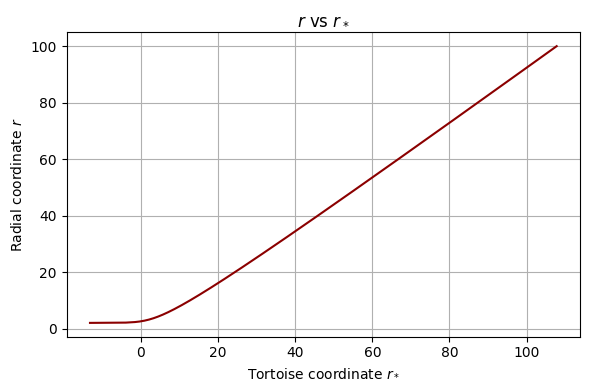

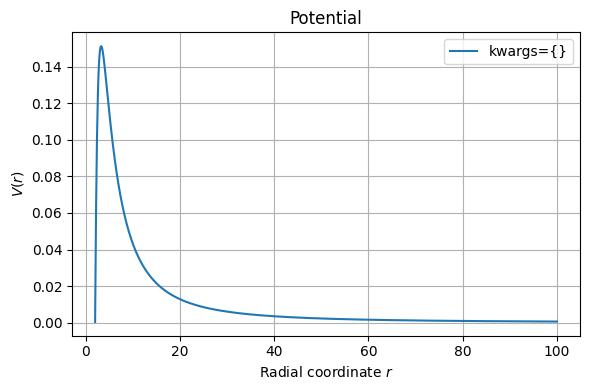

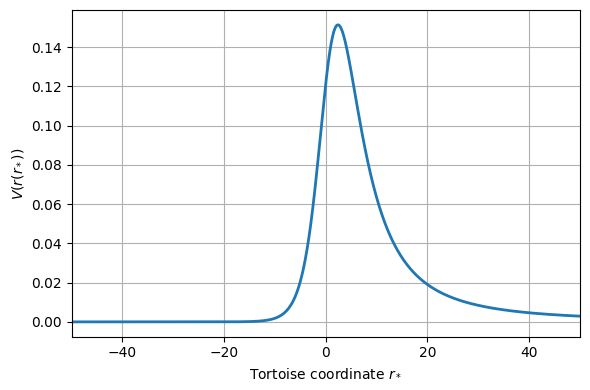

Maximum V(r) = 0.15129 at r = 3.27499, r* = 2.37456


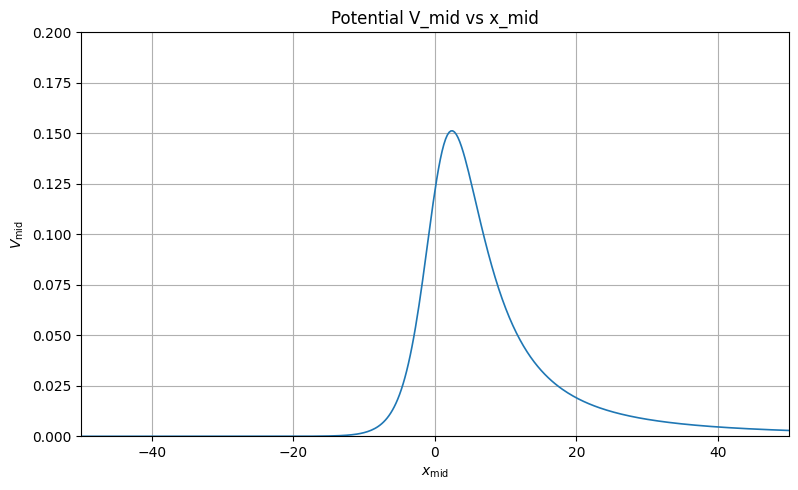

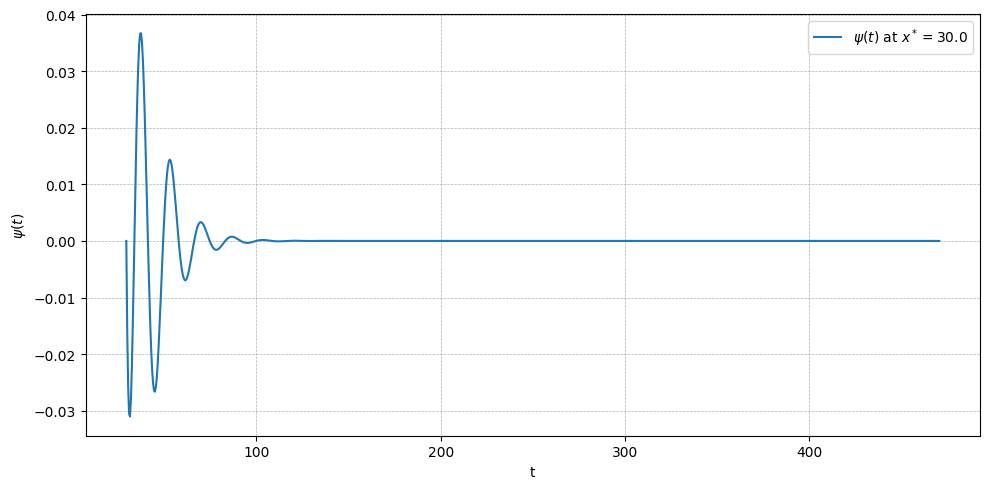

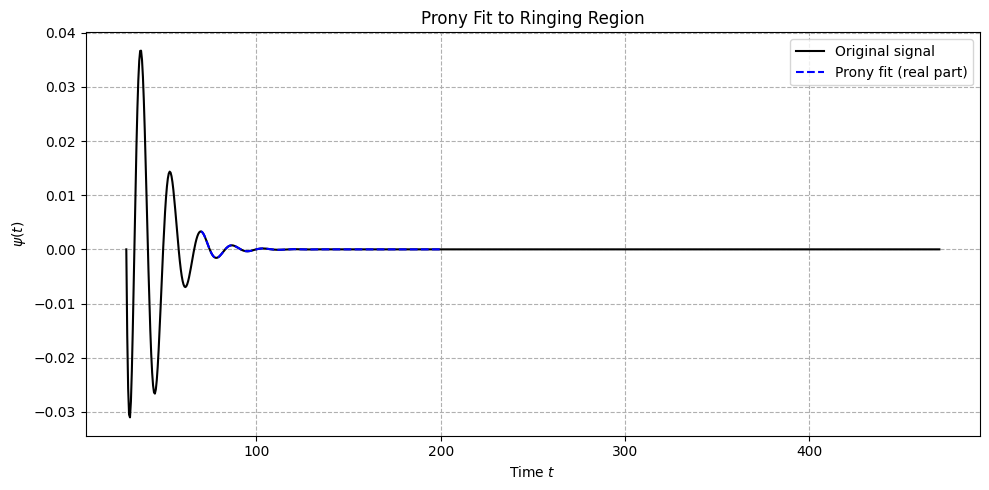

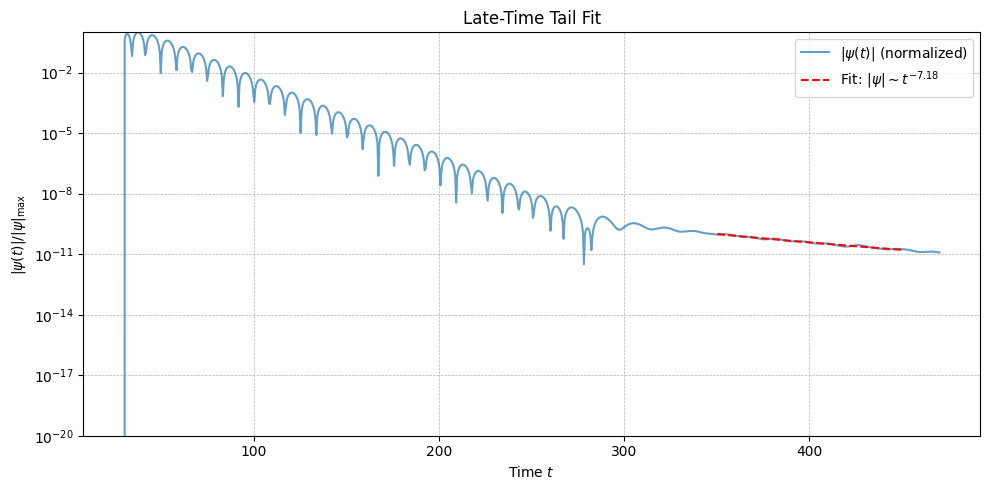

Extracted QNM frequencies (ω = ω_R - i ω_I):
Mode 2: ω = 0.37380 - i 0.08878


[(-0.3737966995574191-0.08878414441798622j),
 (0.3737966995574191-0.08878414441798622j)]

In [12]:
M = 1.0
epsilon = 1e-3
r_values = np.linspace(2*M + epsilon, 100, 1001)
rstar_vals = np.linspace(-50, 50, 4001)
l = 2
s = 2
plot_potential(V_RW, r_values, rstar_vals, M=1.0)

u = np.linspace(0,500,1000)
v = np.linspace(0,500,1000)

psi, x_mid, V_mid, h = wave_integrator(
    u, v, V_RW, M=1.0, 
    use_analytic=False, 
    rstar_of_r=rstar_of_r, r_of_rstar=r_of_rstar)

x_obs = 30.0

signal_array, time_array = observe_signal(
    psi, u, v, x_obs, h,
    x_mid_list=x_mid,
    V_mid_list=V_mid,
    mode="Numerical",   # <--- mode
    M=1.0
)

analyze_signal(
    signal_array, time_array,
    t_fit_range=(70,200), tail_fit_range=(350,450), p=2,
    mode="Numerical",  # "analytic" or "numerical"
    rstar_func=None, r_func=None, M=1.0
)


In [ ]:
def animate_wave_interaction(psi, u, v, x_mid_list, V_mid_list, 
                             filename="wave_interaction.mp4",
                             magnify_outgoing=10.0,
                             observer_x_star=30.0):
    """
    Creates an intuitive animation of wave scattering, showing how a stationary
    observer builds a signal over time.

    Parameters:
    ----------
    psi : np.ndarray
        The evolved wave field.
    u, v : np.ndarray
        The grid arrays.
    x_mid_list, V_mid_list : list
        The midpoint coordinates and potential values.
    filename : str, optional
        The name of the output video file.
    magnify_outgoing : float, optional
        Factor to magnify the outgoing wave's amplitude.
    observer_x_star : float, optional
        The tortoise coordinate x* of the stationary observer.
    """
    # 1. Setup the main figure and axes
    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax2 = ax1.twinx()

    # 2. Plot the potential barrier
    x_mid_array = np.array(x_mid_list)
    V_mid_array = np.array(V_mid_list)
    sorted_indices = np.argsort(x_mid_array)
    unique_x, unique_indices = np.unique(x_mid_array[sorted_indices], return_index=True)
    unique_V = V_mid_array[sorted_indices][unique_indices]
    x_peak_potential = unique_x[np.argmax(unique_V)] if unique_x.size > 0 else 0.0
    ax2.plot(unique_x, unique_V, 'r--', alpha=0.7, linewidth=2, label=r'Potential $V(x^*)$')
    ax2.set_ylabel(r'Potential $V(x^*)$', color='r', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(0, np.max(unique_V) * 1.2 if unique_V.size > 0 else 0.2)
    ax2.grid(False)

    # 3. Add the visual observer line on the main plot
    ax1.axvline(x=observer_x_star, color='purple', linestyle=':', linewidth=2.5, 
                label=f'Observer at x*={observer_x_star:.0f}')

    # 4. Initialize animated lines for the main plot
    x_star_initial = 0.5 * (v - u[0])
    max_psi_abs = np.max(np.abs(psi))
    line, = ax1.plot(x_star_initial, psi[0, :], 'b-', linewidth=2, label=r'$\psi(t, x^*)$')
    line_outgoing, = ax1.plot([], [], 'g-', linewidth=2)
    if magnify_outgoing and magnify_outgoing > 1:
        line_outgoing.set_label(rf'$\psi$ (Outgoing, {magnify_outgoing:.0f}x)')
    time_text = ax1.text(0.05, 0.92, '', transform=ax1.transAxes, fontsize=14)

    # 5. Setup the inset plot for the observer's signal
    ax_inset = fig.add_axes([0.68, 0.68, 0.2, 0.2]) # [left, bottom, width, height]
    line_inset, = ax_inset.plot([], [], 'k-', linewidth=1.5)
    ax_inset.set_title("Observer's Signal", fontsize=10)
    ax_inset.set_xlabel('Time t', fontsize=8)
    ax_inset.set_ylabel(r'$\psi_{obs}$', fontsize=8)
    ax_inset.grid(True, linestyle='--', alpha=0.6)
    observed_time, observed_psi = [], []

    # 6. Set main plot labels and limits
    ax1.set_xlabel(r'Tortoise Coordinate $x^*$', fontsize=14)
    ax1.set_ylabel(r'Scalar Field $\psi$', fontsize=14)
    ax1.set_title('Wave Packet Scattering and Signal Observation', fontsize=16)
    ax1.set_xlim(np.min(0.5 * (v - u[-1])), np.max(x_star_initial))
    ax1.set_ylim(-max_psi_abs * 1.1, max_psi_abs * 1.1)
    ax1.grid(True, which='both', linestyle='--', alpha=0.5)
    fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.65))

    # 7. Define the update function for the animation
    def update(frame_index):
        # Update spatial wave data
        wave_profile = psi[frame_index, :]
        current_x_star = 0.5 * (v - u[frame_index])
        line.set_data(current_x_star, wave_profile)

        # Update magnified outgoing wave
        if magnify_outgoing and magnify_outgoing > 1:
            outgoing_mask = current_x_star > x_peak_potential
            psi_out_magnified = wave_profile[outgoing_mask] * magnify_outgoing
            line_outgoing.set_data(current_x_star[outgoing_mask], psi_out_magnified)
        
        # --- Update the observer's signal ---
        current_time = u[frame_index]
        psi_at_observer = np.interp(observer_x_star, current_x_star, wave_profile)
        observed_time.append(current_time)
        observed_psi.append(psi_at_observer)
        line_inset.set_data(observed_time, observed_psi)
        
        # Rescale inset axes
        ax_inset.relim()
        ax_inset.autoscale_view(True, True, True)

        time_text.set_text(rf'$t \approx {current_time:.2f}$')
        return line, line_outgoing, line_inset, time_text

    # 8. Create and save the animation
    num_frames = psi.shape[0]
    ani = FuncAnimation(fig, update, frames=num_frames, interval=30, blit=False)
    
    print(f"Saving animation to {filename}...")
    try:
        ani.save(filename, writer='ffmpeg', dpi=150, progress_callback=lambda i, n: print(f'Saving frame {i+1} of {n}'))
        print("Animation saved successfully.")
    except Exception as e:
        print(f"Error saving animation. Is 'ffmpeg' installed? Error: {e}")

    plt.close(fig)

animate_wave_interaction(psi, u, v, x_mid, V_mid, magnify_outgoing=10.0)

Saving animation to wave_interaction.mp4...
Saving frame 1 of 1000
Saving frame 2 of 1000
Saving frame 3 of 1000
Saving frame 4 of 1000
Saving frame 5 of 1000
Saving frame 6 of 1000
Saving frame 7 of 1000
Saving frame 8 of 1000
Saving frame 9 of 1000
Saving frame 10 of 1000
Saving frame 11 of 1000
Saving frame 12 of 1000
Saving frame 13 of 1000
Saving frame 14 of 1000
Saving frame 15 of 1000
Saving frame 16 of 1000
Saving frame 17 of 1000
Saving frame 18 of 1000
Saving frame 19 of 1000
Saving frame 20 of 1000
Saving frame 21 of 1000
Saving frame 22 of 1000
Saving frame 23 of 1000
Saving frame 24 of 1000
Saving frame 25 of 1000
Saving frame 26 of 1000
Saving frame 27 of 1000
Saving frame 28 of 1000
Saving frame 29 of 1000
Saving frame 30 of 1000
Saving frame 31 of 1000
Saving frame 32 of 1000
Saving frame 33 of 1000
Saving frame 34 of 1000
Saving frame 35 of 1000
Saving frame 36 of 1000
Saving frame 37 of 1000
Saving frame 38 of 1000
Saving frame 39 of 1000
Saving frame 40 of 1000
Savin